# Imports

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

In [2]:
#so many imports...
warnings.filterwarnings('ignore')
#I'm not sure I really love the idea of just ignoring warnings. Though I suppose if it's just for like depretiation stuff it's no big deal

In [3]:
plt.style.use("fivethirtyeight")

In [4]:
#setting up the api
quandl.ApiConfig.api_key='E821LFs4vxG5G64LGUiz'

So I looked on Quandl for some real esate type stuff but all I found was Zillow. Which is interesting but not stricktly speaking a good set for this exersize. Thats when I decided to go back to the FRED page and I found a section on Housing Starts. This is, quote investopedia, __"the number of new residential construction projects that begin during any particular month"__. How cool is that? I wont really be able to tie it directly to the Airbnb set because that one actually lacks a solid time series section. The only dates are on the last time someone reviewd a listing. It's an interesting stat though becaue it can be one (of many) "key indicators" of economic strength or weakness. There is _a lot_ going on in this but we're just looking at the raw numbers. That said I might come back to it on my own because _this cake has some layers_.

In [5]:
#loading in that set
df_home=quandl.get('FRED/HOUST')

In [6]:
df_home.head()

,Value
Date,
1959-01-01,1657.0
1959-02-01,1667.0
1959-03-01,1620.0
1959-04-01,1590.0
1959-05-01,1498.0


In [7]:
df_home.shape

(752, 1)

In [7]:
df_home.to_csv(os.path.join(path,'03 Final','quandl_fred_houst.csv'))

NameError: name 'path' is not defined

In [8]:
#just in case
df_home.isnull().sum()

Value    0
dtype: int64

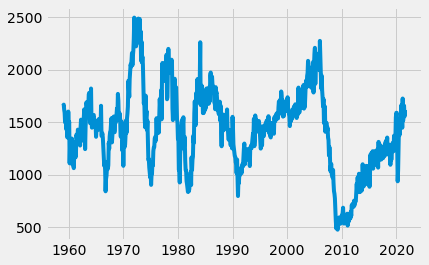

In [9]:
#ok let's get a quick look.
plt.plot(df_home)

# Subsetting

So, the resesion not withstanding, this chart actually might work just fine in terms of being stationairy(though it looks like maybe just the slightest over all negitive trend?). However that's no fun so we're going to slice it down to the last 10ish years.

In [10]:
df_home_2=df_home.reset_index()

In [11]:
df_home_2.head()

,Date,Value
0,1959-01-01,1657.0
1,1959-02-01,1667.0
2,1959-03-01,1620.0
3,1959-04-01,1590.0
4,1959-05-01,1498.0


In [12]:
#now we can filter it out a little.
df_home_2=df_home_2.loc[(df_home_2['Date']>='2010-01-01' )& (df_home_2['Date']<='2020-01-01')]

In [13]:
df_home_2.head()

,Date,Value
612,2010-01-01,614.0
613,2010-02-01,604.0
614,2010-03-01,636.0
615,2010-04-01,687.0
616,2010-05-01,583.0


In [15]:
#ok cool looks like that worked. Next we need to re-index date which takes a few steps but should be pretty quick
#first we import the datetime function
from datetime import datetime
#now we need to make a new column derived from the date column
df_home_2['datetime']=pd.to_datetime(df_home_2['Date'])
#next we set the index to the datetime colimn
df_home_2=df_home_2.set_index('datetime')
#finally we drop the old date one
df_home_2.drop(['Date'],axis=1,inplace=True)
#and then we'll run a .head just to check it out
df_home_2.head()

,Value
datetime,
2010-01-01,614.0
2010-02-01,604.0
2010-03-01,636.0
2010-04-01,687.0
2010-05-01,583.0


In [17]:
type(df_home_2)

pandas.core.frame.DataFrame

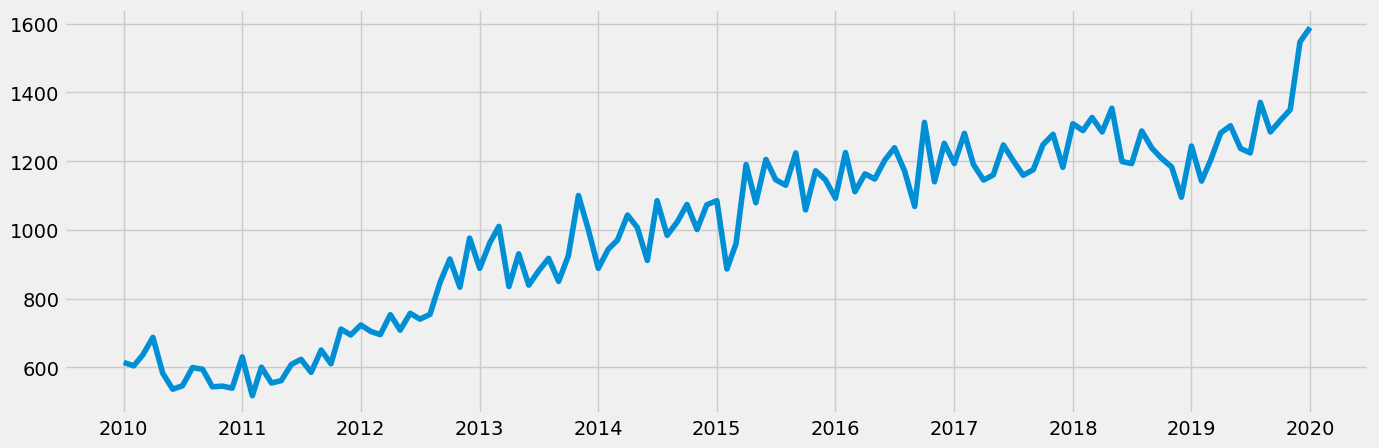

In [18]:
#lovely. Now we'll plot it out real quick, though a little more elegantly than the quick and dirty one I did above haha
plt.figure(figsize=(15,5),dpi=100)
plt.plot(df_home_2)

_so trendy_

In [19]:
#just to be safe we'll do a quick null and doubles check.
df_home_2.isnull().sum()

Value    0
dtype: int64

In [20]:
df_dubs=df_home_2.duplicated()
df_dubs.sum()

8

In [21]:
df_home_2.shape

(121, 1)

In [22]:
#oh shoot, good thing we checked!
df_home_2=df_home_2.drop_duplicates()

In [23]:
df_home_2.shape

(113, 1)

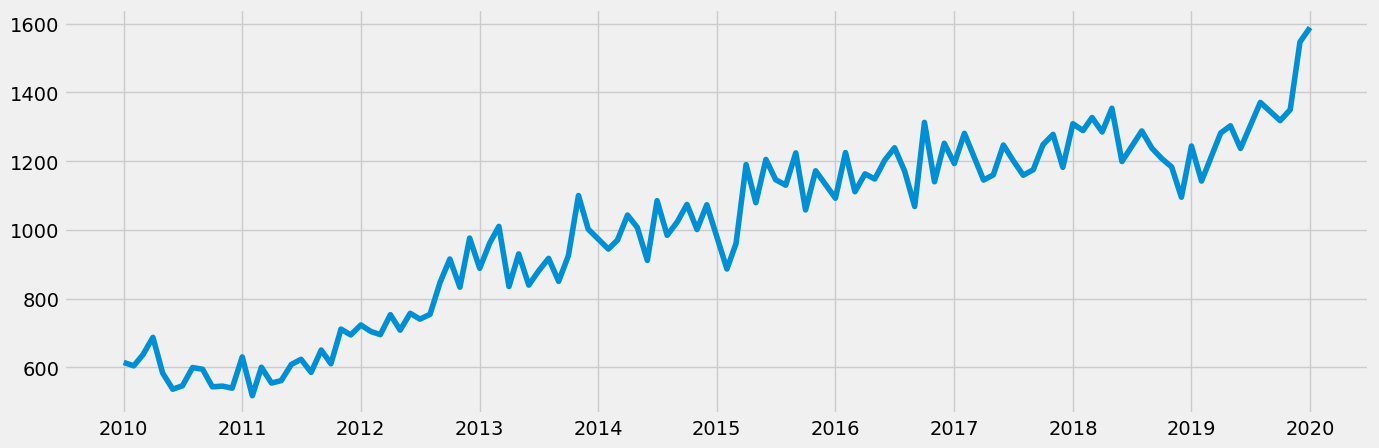

In [24]:
plt.figure(figsize=(15,5),dpi=100)
plt.plot(df_home_2)

In [25]:
#cool beans! next up..

# Decomposition!
a word that always reminds me of a funny [Far Side](https://i.pinimg.com/736x/ab/5a/61/ab5a61c80e14809f9fcb7205d86fd0a4--weird-things-fun-things.jpg) comic from ages ago

In [30]:
# I'm assuming this data is additive btw
decomposition = sm.tsa.seasonal_decompose(df_home_2, model='additive',period=12)

In [48]:
#I'm telling you I think it took me almost an hour to figure out that for some reason it wanted that period=12 bit.
#uhg.
#I went with 12 because if I understand it correctly it is the period of each cycle, and each cycle is a year and the data is monthly

In [33]:
from pylab import rcParams
rcParams['figure.figsize'] =18,7

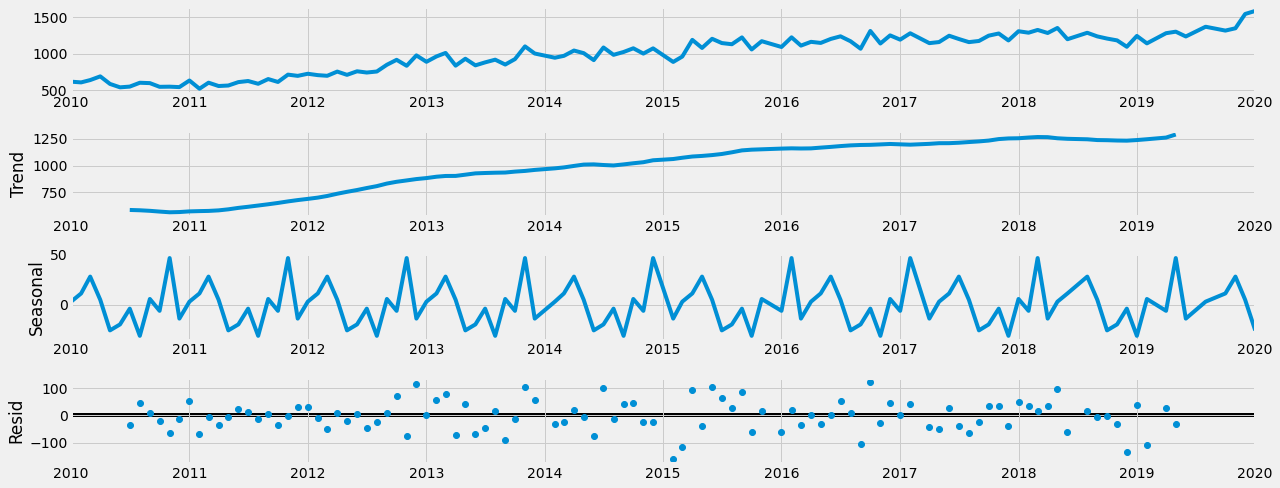

In [35]:
decomposition.plot()
plt.show()

# Stationarity teststing!
I can't even say that word right _in my head_ I hope I never have to say it out loud

In [37]:
#first things first we'll set up the Dickey Fully test as a defined function
from statsmodels.tsa.stattools import adfuller

In [44]:
def dickey_fuller(timeseries):
    print('Dickey Fuller Stationary Testing')
    test=adfuller(timeseries, autolag='AIC')
    result=pd.Series(test[0:4],index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value(%s)'%key]=value
    print(result)

In [39]:
#While I'm in a sort prep mood I'm going to import the bits for the autocorr test
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [45]:
#Dickey Fuller test!
dickey_fuller(df_home_2['Value'])

Dickey Fuller Stationary Testing
Test Statistic                   0.112714
p-value                          0.966919
Number of Lags Used              2.000000
Number of Observations Used    110.000000
Critical Value(1%)              -3.491245
Critical Value(5%)              -2.888195
Critical Value(10%)             -2.580988
dtype: float64


In [46]:
#wow, the test stat is much bigger than any of the crit values! But I suppose that makes sense

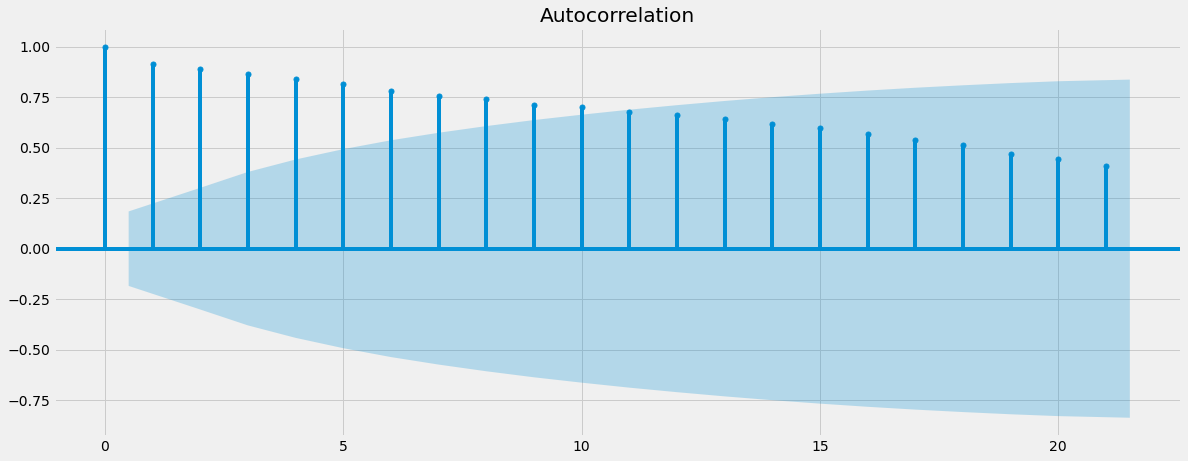

In [47]:
#now for the autocorr stuff
plot_acf(df_home_2)
plt.show()

In [49]:
#how exciting
#OK TIME TO DO SOME MATH MAGIC

In [50]:
df_diff=df_home_2 - df_home_2.shift(1)
df_diff.dropna(inplace=True)

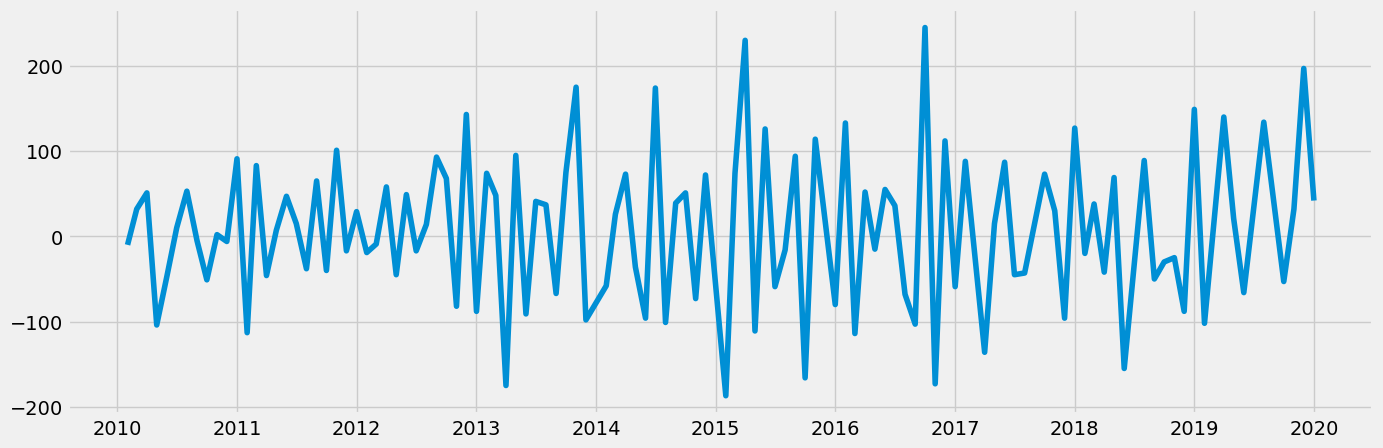

In [51]:
plt.figure(figsize=(15,5),dpi=100)
plt.plot(df_diff)

In [53]:
#haha man, that's a crazy line, but it actually does look stationary. Let's check!
dickey_fuller(df_diff)

Dickey Fuller Stationary Testing
Test Statistic                -1.149826e+01
p-value                        4.557797e-21
Number of Lags Used            1.000000e+00
Number of Observations Used    1.100000e+02
Critical Value(1%)            -3.491245e+00
Critical Value(5%)            -2.888195e+00
Critical Value(10%)           -2.580988e+00
dtype: float64


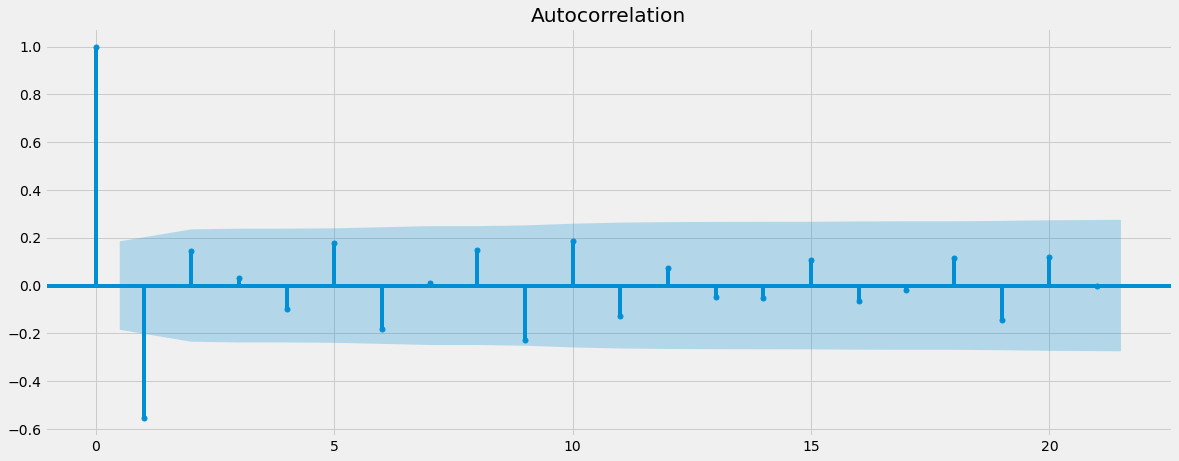

In [54]:
#I think it worked, just to double check here
plot_acf(df_diff)
plt.show()

In [55]:
#oh yeah. Very nice.